# Experiment 4: General-Sum Games & Social Welfare

**Objective**: Investigate the behavior of no-regret learning in **general-sum games**, where players' interests are not strictly opposed.

**Context**: In zero-sum games, Nash Equilibrium is the undisputed solution concept. In general-sum games (like the Prisoner's Dilemma), Nash Equilibria can be suboptimal for the group (low Social Welfare). We want to see if CFR converges to these "rational but selfish" outcomes or if it finds cooperative ones.

**Games**:
1.  **3-Player Goofspiel**: A competitive card game (constant-sum-ish) to test multiplayer convergence.
2.  **3-Player Prisoner's Dilemma**: A classic general-sum game to test cooperation vs. defection.

In [1]:
%matplotlib inline
import pyspiel
import numpy as np
import matplotlib.pyplot as plt
from solvers import CFRPlusSolver
from open_spiel.python.algorithms import exploitability

print("Ready for General-Sum analysis!")

Optional module pokerkit_wrapper was not importable: No module named 'pokerkit'
Ready for General-Sum analysis!


Loading 3-player Goofspiel (Turn-based)...
Training CFR+ for 5000 iterations...
Iteration 5000/5000 - NashConv: 0.002153


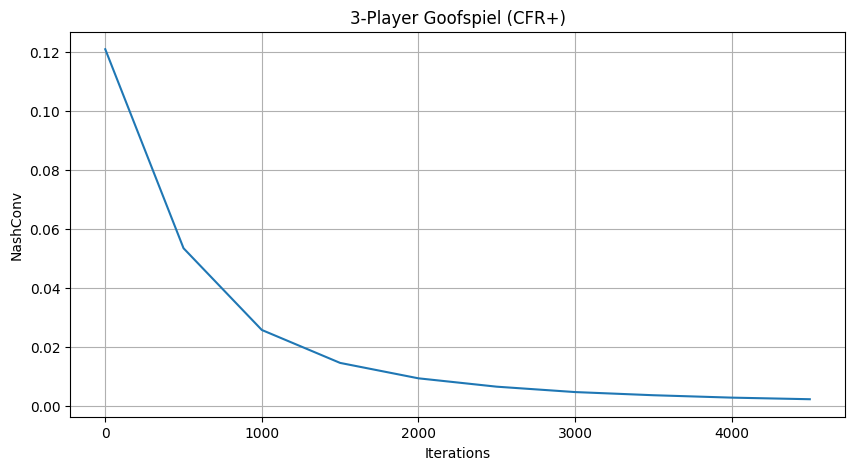

Final NashConv (Goofspiel): 0.002153


In [2]:
# Part 1: 3-Player Goofspiel
print("Loading 3-player Goofspiel (Turn-based)...")
# Wrap simultaneous Goofspiel to be turn-based so our CFR solver can handle it
game_string = "turn_based_simultaneous_game(game=goofspiel(players=3,num_cards=3,imp_info=True))"
game = pyspiel.load_game(game_string)

solver = CFRPlusSolver(game)
iterations = 5000
log_every = 500

print(f"Training CFR+ for {iterations} iterations...")
history = solver.train(iterations, log_every=log_every)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(history)) * log_every, history)
plt.title("3-Player Goofspiel (CFR+)")
plt.xlabel("Iterations")
plt.ylabel("NashConv")
plt.grid(True)
plt.show()

print(f"Final NashConv (Goofspiel): {history[-1]:.6f}")


Creating 3-Player Prisoner's Dilemma...
Training CFR+ on Prisoner's Dilemma for 5000 iterations...


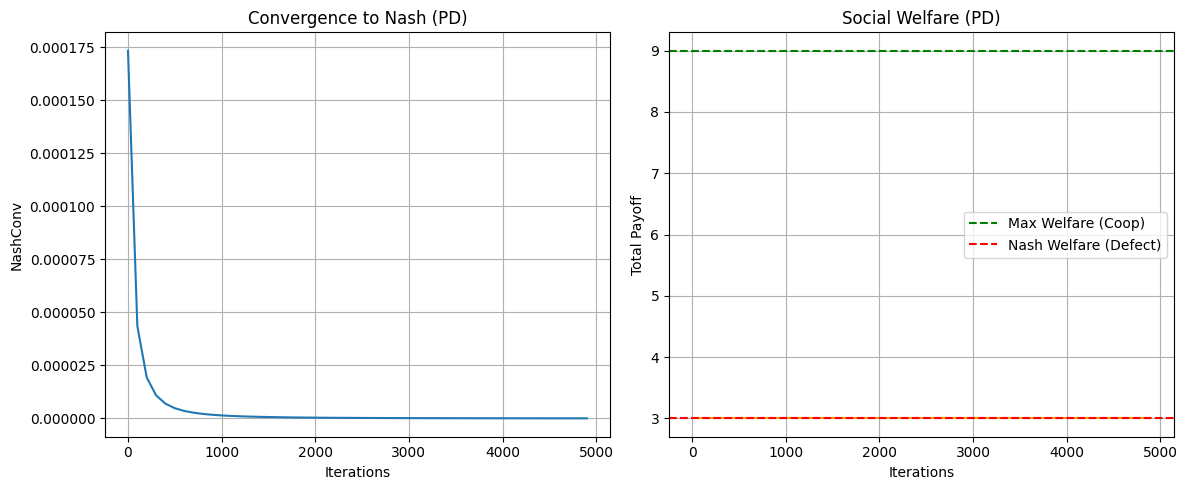

Final NashConv: 0.000000
Final Welfare: 3.00 (Expected: ~3.0 for Nash, 9.0 for Coop)


In [3]:
# Part 2: 3-Player Prisoner's Dilemma (True Variable-Sum)
print("\nCreating 3-Player Prisoner's Dilemma...")

# We define the payoff tensors directly as numpy arrays
# Shape: (2, 2, 2) for (P0_action, P1_action, P2_action)
# Action 0 = Cooperate, 1 = Defect

p0_payoffs = np.zeros((2, 2, 2))
p1_payoffs = np.zeros((2, 2, 2))
p2_payoffs = np.zeros((2, 2, 2))

# Fill payoffs
# C=0, D=1
# All C (0,0,0) -> 3
# All D (1,1,1) -> 1
# 1 D, 2 C -> Defector gets 5, Cooperators get 0
# 2 D, 1 C -> Defectors get 2, Cooperator gets 0 (Sucker)

for a0 in range(2):
    for a1 in range(2):
        for a2 in range(2):
            actions = [a0, a1, a2]
            num_defectors = sum(actions)
            
            if num_defectors == 0: # CCC
                rewards = [3, 3, 3]
            elif num_defectors == 1:
                # The defector gets 5, others 0
                rewards = [5 if a == 1 else 0 for a in actions]
            elif num_defectors == 2:
                # Defectors get 2, Cooperator gets 0
                rewards = [2 if a == 1 else 0 for a in actions]
            else: # DDD
                rewards = [1, 1, 1]
            
            p0_payoffs[a0, a1, a2] = rewards[0]
            p1_payoffs[a0, a1, a2] = rewards[1]
            p2_payoffs[a0, a1, a2] = rewards[2]

# Create tensor game from list of arrays
tensor_game = pyspiel.create_tensor_game([p0_payoffs, p1_payoffs, p2_payoffs])

# Convert to turn-based game using the helper function
game = pyspiel.convert_to_turn_based(tensor_game)

solver = CFRPlusSolver(game)
iterations = 5000
log_every = 100

print(f"Training CFR+ on Prisoner's Dilemma for {iterations} iterations...")

nash_conv_history = []
welfare_history = []

for i in range(iterations):
    for player in range(3):
        solver.cfr(game.new_initial_state(), player, i)
    
    if (i + 1) % log_every == 0:
        policy = solver.get_policy()
        nash_conv = exploitability.nash_conv(game, policy)
        nash_conv_history.append(nash_conv)
        
        # Calculate Social Welfare
        total_welfare = 0
        for _ in range(100):
            state = game.new_initial_state()
            while not state.is_terminal():
                if state.is_chance_node():
                    action = np.random.choice([o[0] for o in state.chance_outcomes()], p=[o[1] for o in state.chance_outcomes()])
                else:
                    p_probs = policy.action_probabilities(state)
                    actions = list(p_probs.keys())
                    probs = list(p_probs.values())
                    action = np.random.choice(actions, p=probs)
                state.apply_action(action)
            total_welfare += sum(state.returns())
        welfare_history.append(total_welfare / 100)

# Plot NashConv
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(nash_conv_history)) * log_every, nash_conv_history)
plt.title("Convergence to Nash (PD)")
plt.xlabel("Iterations")
plt.ylabel("NashConv")
plt.grid(True)

# Plot Social Welfare
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(welfare_history)) * log_every, welfare_history, color='orange')
plt.axhline(y=9, color='g', linestyle='--', label="Max Welfare (Coop)")
plt.axhline(y=3, color='r', linestyle='--', label="Nash Welfare (Defect)")
plt.title("Social Welfare (PD)")
plt.xlabel("Iterations")
plt.ylabel("Total Payoff")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final NashConv: {nash_conv_history[-1]:.6f}")
print(f"Final Welfare: {welfare_history[-1]:.2f} (Expected: ~3.0 for Nash, 9.0 for Coop)")

## Result Interpretation

1.  **Goofspiel**: CFR successfully finds a Nash Equilibrium (NashConv -> 0) in this competitive multiplayer game, showing its robustness beyond 2-player zero-sum.
2.  **Prisoner's Dilemma**: 
    *   **Nash Convergence**: The algorithm quickly converges to NashConv = 0.
    *   **Social Welfare**: The total welfare converges to ~3.0 (Everyone Defects). This confirms that no-regret learning, by minimizing individual regret, drives agents to the **rational but selfish** equilibrium (Defect-Defect-Defect), sacrificing the higher social welfare of ~9.0 (Cooperate-Cooperate-Cooperate).
    *   **Conclusion**: Standard CFR is "safe" but not "pro-social". It avoids being exploited but fails to cooperate.